In [1]:
from transformers import AutoFeatureExtractor

c:\Users\Trieu\OneDrive\Documents\Programming\YOLO Training\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from datasets import load_dataset, Image
dataset = load_dataset("timm/imagenet-1k-wds", split="train", streaming = True)

image = next(iter(dataset))

In [17]:
image = image['jpg']

In [ ]:

feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small")

pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
pixel_values.shape


c:\Users\Trieu\OneDrive\Documents\Programming\YOLO Training\.venv\Lib\site-packages\transformers\models\yolos\feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


torch.Size([1, 3, 800, 1056])

In [10]:
from transformers import YolosForObjectDetection

model = YolosForObjectDetection.from_pretrained("hustvl/yolos-small")

In [11]:
import torch

with torch.no_grad():
  outputs = model(pixel_values, output_attentions=True)

`YolosSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [ ]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{model.config.id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    # keep only predictions of queries with 0.9+ confidence (excluding no-object class)



In [21]:
probas = outputs.logits.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# rescale bounding boxes
target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
bboxes_scaled = postprocessed_outputs[0]['boxes']


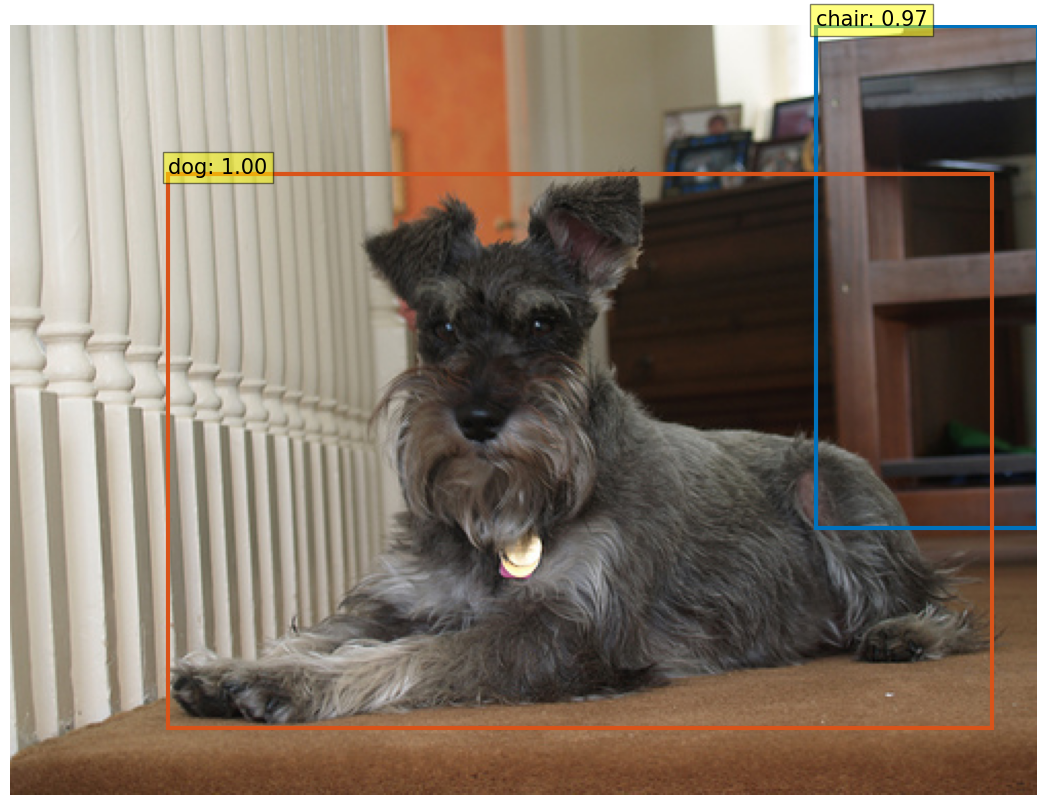

In [22]:
plot_results(image, probas[keep], bboxes_scaled[keep])
